## Installing and importing required libraries :

In [1]:
! pip install pandas-datareader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding, Activation, LSTM

In [4]:
key = 'paste here your tiingo API Token found here : https://api.tiingo.com/documentation/general/overview'

In [5]:
df = pdr.get_data_tiingo('AAPL',api_key = key)

/usr/local/lib/python3.8/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [6]:
df.to_csv('AAPL.csv')

In [7]:
df = pd.read_csv('/content/AAPL.csv')

In [8]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-12-18 00:00:00+00:00,176.42,177.20,174.86,174.88,28831533,41.937498,42.122915,41.566664,41.571419,115326132,0.0,1.0
1,AAPL,2017-12-19 00:00:00+00:00,174.54,175.39,174.09,175.03,27078872,41.490596,41.692653,41.383624,41.607076,108315488,0.0,1.0
2,AAPL,2017-12-20 00:00:00+00:00,174.35,175.42,173.25,174.87,23000392,41.445430,41.699784,41.183945,41.569041,92001568,0.0,1.0
3,AAPL,2017-12-21 00:00:00+00:00,175.01,176.02,174.10,174.17,20356826,41.602321,41.842412,41.386002,41.402642,81427304,0.0,1.0
4,AAPL,2017-12-22 00:00:00+00:00,175.01,175.42,174.50,174.68,16052615,41.602321,41.699784,41.481087,41.523876,64210460,0.0,1.0


In [9]:
df1 = df.reset_index()['close']

In [10]:
df1.shape

(1259,)

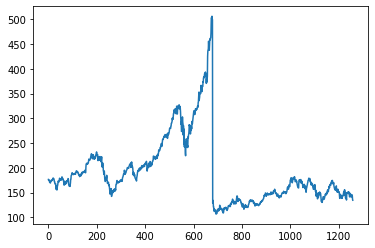

In [11]:
plt.plot(df1)

In [12]:
df1

0       176.42
1       174.54
2       174.35
3       175.01
4       175.01
         ...  
1254    144.49
1255    145.47
1256    143.21
1257    136.50
1258    134.51
Name: close, Length: 1259, dtype: float64

## Splitting and Scaling :

In [13]:
len(df1)

1259

In [14]:
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=np.array(df1).reshape(-1,1)[0:training_size,:],np.array(df1).reshape(-1,1)[training_size:len(df1),:1]

In [15]:
training_size,test_size 

(881, 378)

In [16]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [17]:
test_data[0:12,:]

array([[0.06376957],
       [0.06797746],
       [0.06727614],
       [0.06654978],
       [0.06579837],
       [0.06998121],
       [0.07386349],
       [0.07544145],
       [0.07621791],
       [0.08295554],
       [0.08811522],
       [0.09450219]])

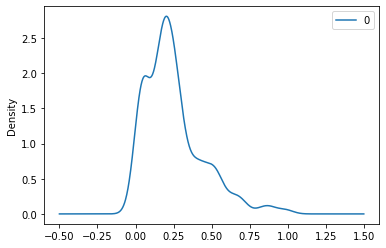

In [18]:
pd.DataFrame(train_data).plot(kind='density', subplots=True, sharex=False)
plt.show();

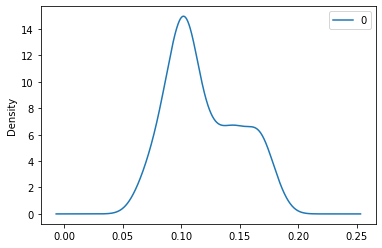

In [19]:
pd.DataFrame(test_data).plot(kind='density', subplots=True, sharex=False)
plt.show();

## Creating time series Data :

### Treating instances as if they are features :

In [20]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
time_step = 100
X_train , y_train = create_dataset(train_data, time_step)
X_test , y_test = create_dataset(test_data, time_step)

In [22]:
X_train.shape,y_train.shape

((780, 100), (780,))

In [23]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Creating Model :

In [24]:
model=Sequential()
model.add(LSTM(80,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(60,return_sequences=True))
model.add(LSTM(50))
#model.add(LSTM(50,return_sequences=True))
model.add(Dropout(.4))
model.add(Dense(1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 80)           26240     
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           33840     
                                                                 
 lstm_2 (LSTM)               (None, 50)                22200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 82,331
Trainable params: 82,331
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=.001))

### Training

In [27]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
25/25 [==============================] - 12s 118ms/step - loss: 0.0203 - val_loss: 0.0019
Epoch 2/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0125 - val_loss: 6.7962e-04
Epoch 3/100
25/25 [==============================] - 1s 31ms/step - loss: 0.0092 - val_loss: 3.3824e-04
Epoch 4/100
25/25 [==============================] - 1s 32ms/step - loss: 0.0088 - val_loss: 3.5891e-04
Epoch 5/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0081 - val_loss: 4.3220e-04
Epoch 6/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0088 - val_loss: 3.4585e-04
Epoch 7/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0068 - val_loss: 8.1287e-04
Epoch 8/100
25/25 [==============================] - 1s 32ms/step - loss: 0.0065 - val_loss: 6.2264e-04
Epoch 9/100
25/25 [==============================] - 1s 31ms/step - loss: 0.0061 - val_loss: 2.9536e-04
Epoch 10/100
25/25 [==============================] - 1s 32ms/step

In [28]:
y_hat_tr=model.predict(X_train)
y_hat_ts=model.predict(X_test)

9/9 [==============================] - 0s 13ms/step


### Projecting predicted values back to their original form :

In [29]:
y_hat_tr=scaler.inverse_transform(y_hat_tr)
y_hat_ts=scaler.inverse_transform(y_hat_ts)

In [30]:
y_hat_ts

array([[151.27063],
       [150.91447],
       [150.29462],
       [149.93936],
       [149.88968],
       [150.15628],
       [150.89627],
       [152.41393],
       [154.57018],
       [156.79604],
       [158.65927],
       [160.02046],
       [160.14212],
       [159.89752],
       [160.37827],
       [161.33372],
       [162.22649],
       [162.5933 ],
       [163.04309],
       [164.44464],
       [166.90457],
       [169.52562],
       [172.38277],
       [174.38211],
       [175.16379],
       [175.84465],
       [175.50554],
       [174.34447],
       [172.78671],
       [171.85371],
       [172.01605],
       [172.95677],
       [174.74344],
       [176.57556],
       [177.99817],
       [178.69228],
       [178.7075 ],
       [179.02802],
       [179.27225],
       [178.62389],
       [177.01968],
       [175.19794],
       [173.70535],
       [173.17528],
       [173.44858],
       [173.59596],
       [173.61859],
       [173.081  ],
       [171.7087 ],
       [169.79672],


In [31]:
y_hat_tr.shape

(780, 1)

In [32]:
mean_squared_error(y_train,y_hat_tr)**.5

224.7572880446788

In [33]:
mean_squared_error(y_test,y_hat_ts)**.5

157.93829841382154

## Plotting predicted values for the forecast :

In [34]:
df1.shape

(1259,)

In [35]:
df1.shape[0]

1259

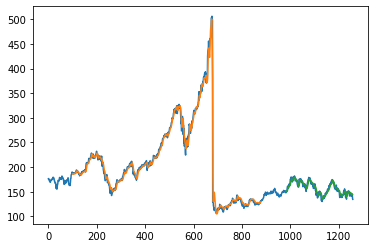

In [36]:
look_back=100
trainPredictPlot = np.zeros((df1.shape[0],1))
trainPredictPlot[look_back:len(y_hat_tr)+look_back, :] = y_hat_tr
# Removing discontinuities in the train plot
trainPredictPlot[np.where(trainPredictPlot ==0)[0]] = np.nan


testPredictPlot = np.zeros((df1.shape[0],1))
testPredictPlot[len(y_hat_tr)+(look_back*2)+1:len(df1)-1, :] = y_hat_ts
# Removing discontinuities in the test plot
testPredictPlot[np.where(testPredictPlot ==0)[0]] = np.nan


# plot baseline and predictions
plt.plot(np.array(df1).reshape(-1,1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Predicting the next 30 days :

In [37]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [39]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
       
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.08822204]
101
1 day input [0.13943644 0.13693175 0.1331747  0.14850344 0.14770194 0.14654978
 0.14534753 0.14547276 0.15629305 0.15441453 0.16345648 0.1661866
 0.16578585 0.16959299 0.16859111 0.16200376 0.15211021 0.15125861
 0.15201002 0.15827176 0.14221666 0.13660614 0.13041954 0.1261866
 0.12804008 0.12265498 0.11944897 0.12303068 0.11927364 0.1265623
 0.14174076 0.11772073 0.12140263 0.11403882 0.10985598 0.11932373
 0.1253851  0.11742016 0.11496556 0.10917971 0.11003131 0.11251096
 0.10770194 0.08926738 0.07854728 0.08919224 0.09833438 0.09908579
 0.09665623 0.08328115 0.0841077  0.08050094 0.07889793 0.09054477
 0.07899812 0.08909205 0.09244834 0.09272386 0.09154665 0.10126487
 0.10672511 0.11396368 0.10647464 0.09507827 0.12247965 0.11646838
 0.10973075 0.09565435 0.08025047 0.07899812 0.08035066 0.08180338
 0.07020664 0.10026299 0.10735128 0.10379461 0.10820288 0.10507201
 0.10990607 0.11133375 0.10311835 0.10855354 0.11078272 0.10336882
 0.09362555 0.08598622 0.10316844 0.

In [44]:
np.array(lst_output)

array([[0.08822204],
       [0.08564417],
       [0.08493036],
       [0.08524691],
       [0.08596519],
       [0.08676837],
       [0.08753309],
       [0.08822469],
       [0.08884171],
       [0.08939348],
       [0.08989269],
       [0.09035298],
       [0.0907879 ],
       [0.09120981],
       [0.09162916],
       [0.09205383],
       [0.09248914],
       [0.09293774],
       [0.09340008],
       [0.09387474],
       [0.09435919],
       [0.09485008],
       [0.0953438 ],
       [0.09583697],
       [0.09632656],
       [0.09681016],
       [0.09728611],
       [0.09775335],
       [0.09821147],
       [0.0986606 ]])

### Plotting the predicted stock values seperately and in detail :

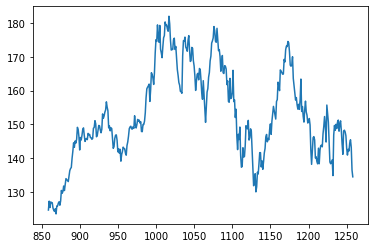

In [45]:
day_new=np.arange(859,1259)
plt.plot(day_new,np.array(df1).reshape(-1,1)[859:1259,0])

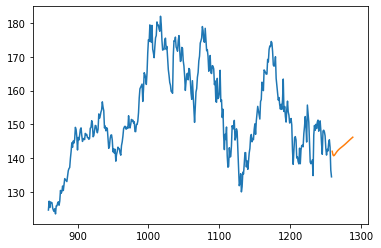

In [47]:
day_pred=np.arange(1259,1289)

# Concatenating the whole time series :
conc = np.concatenate((np.array(df1).reshape(-1,1),scaler.inverse_transform(lst_output)),axis=0)

# plotting
plt.plot(day_new,np.array(df1).reshape(-1,1)[859:1259,0])
plt.plot(day_pred,scaler.inverse_transform(lst_output));

### Putting up all together :

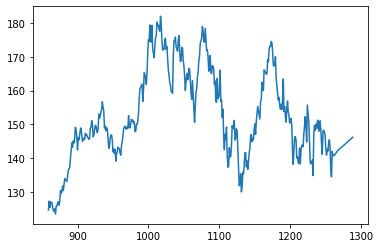

In [42]:
plt.plot(np.arange(859,1289),conc[859:1289,0]);